<a href="https://colab.research.google.com/github/AyoubHAMD/3D-Reconstruction/blob/master/tiny_nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2021-08-01 15:55:30--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bmild.com/nerf/tiny_nerf_data.npz [following]
--2021-08-01 15:55:31--  https://bmild.com/nerf/tiny_nerf_data.npz
Resolving bmild.com (bmild.com)... 216.239.34.21, 216.239.38.21, 216.239.32.21, ...
Connecting to bmild.com (bmild.com)|216.239.34.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bmild.github.io/nerf/tiny_nerf_data.npz [following]
--2021-08-01 15:55:31--  https://bmild.github.io/nerf/tiny_nerf_data.npz
Resolving bmild.github.io (bmild.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bmild.github.io (bmild.github.io)|185.199.108.153|:443... connected.
HTTP re

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103
<built-in method all of numpy.ndarray object at 0x7f179060d7b0>


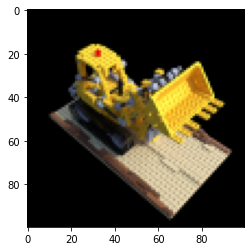

In [9]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [11]:


def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.13717641830444335 secs per iter


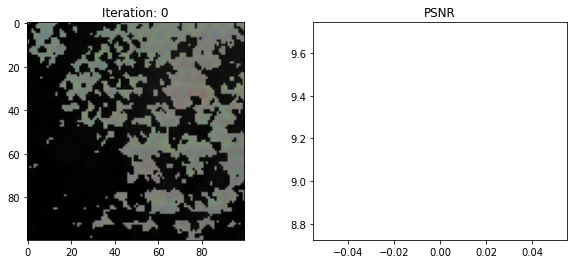

25 1.7579374504089356 secs per iter


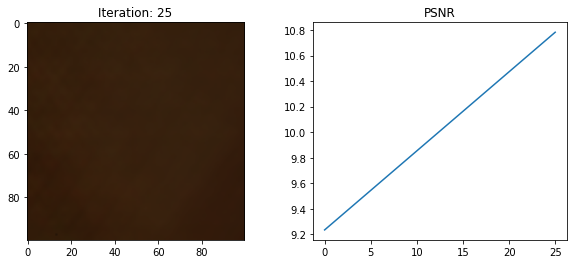

50 1.7348283100128175 secs per iter


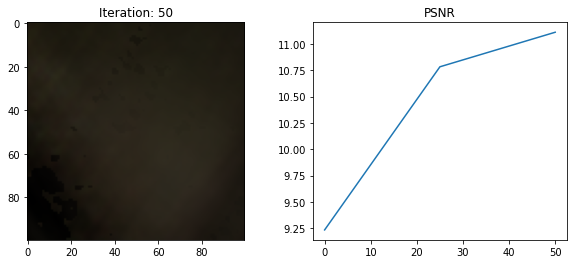

75 1.7178825950622558 secs per iter


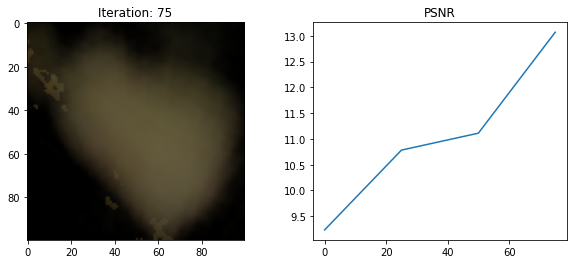

100 1.7103068923950195 secs per iter


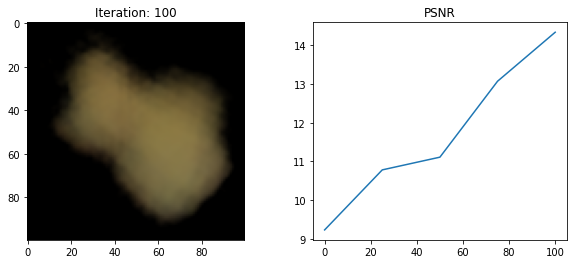

125 1.710209035873413 secs per iter


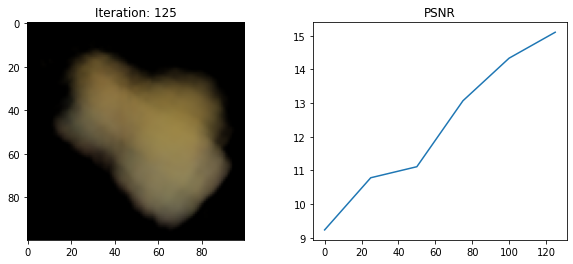

150 1.7074397277832032 secs per iter


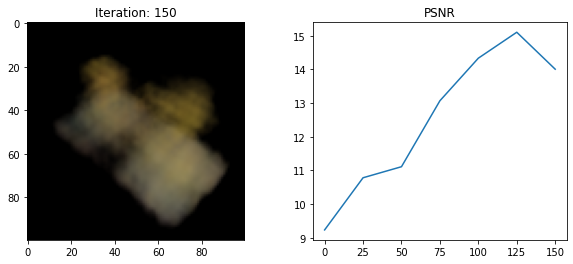

175 1.6986787414550781 secs per iter


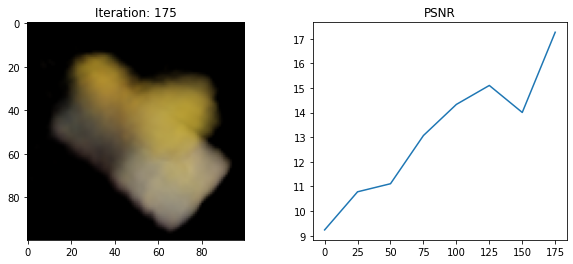

200 1.7090223026275635 secs per iter


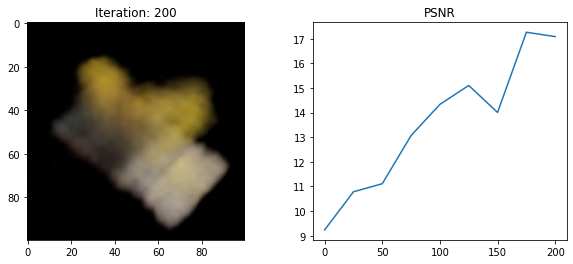

225 1.7112277126312256 secs per iter


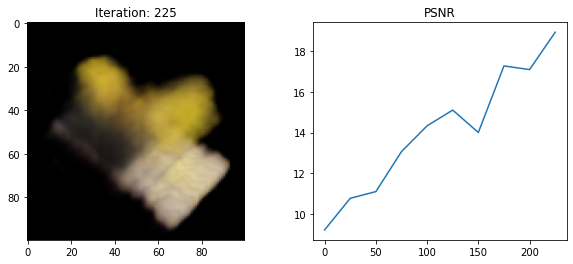

250 1.7088576984405517 secs per iter


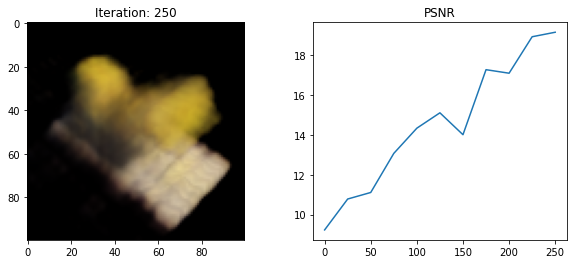

275 1.6978488636016846 secs per iter


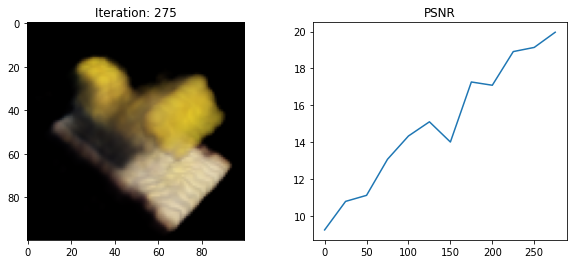

300 1.7067099761962892 secs per iter


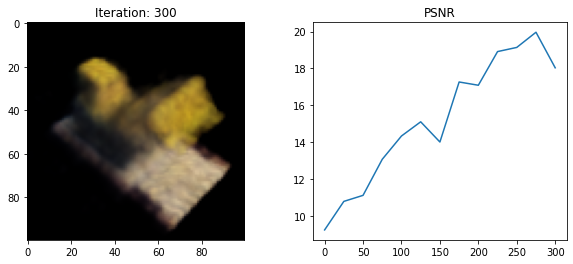

325 1.7063927459716797 secs per iter


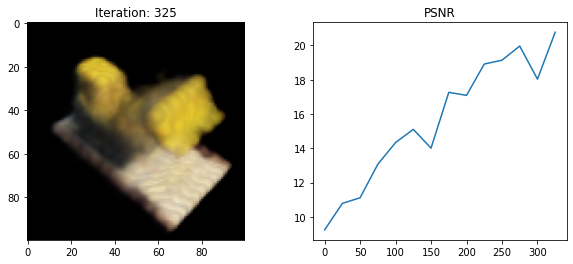

350 1.7110505771636964 secs per iter


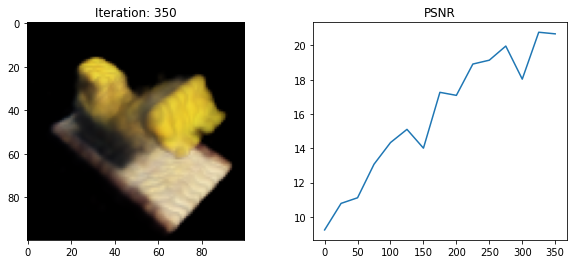

375 1.7015696334838868 secs per iter


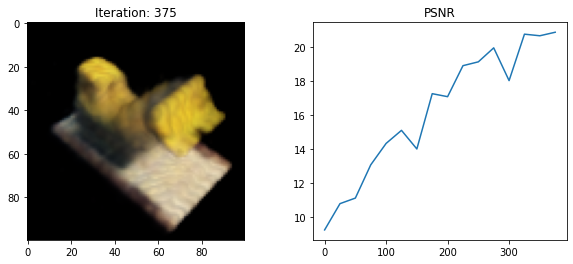

400 1.7035847187042237 secs per iter


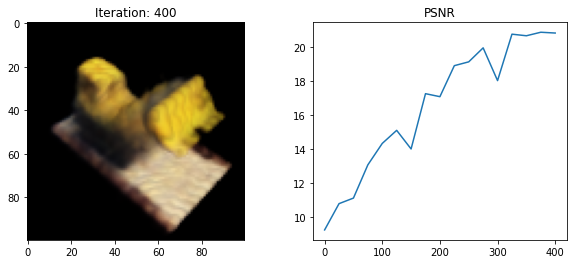

425 1.7056120586395265 secs per iter


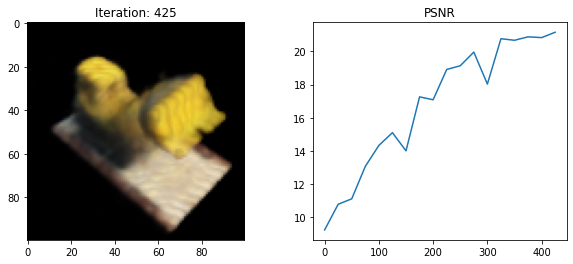

450 1.7075881576538086 secs per iter


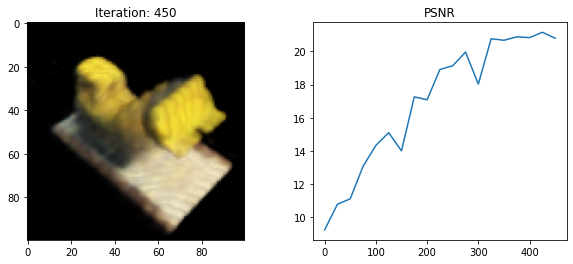

475 1.7035623741149903 secs per iter


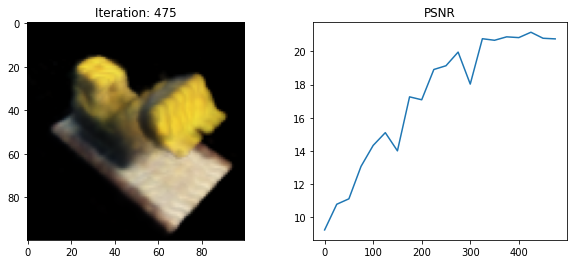

500 1.6975066566467285 secs per iter


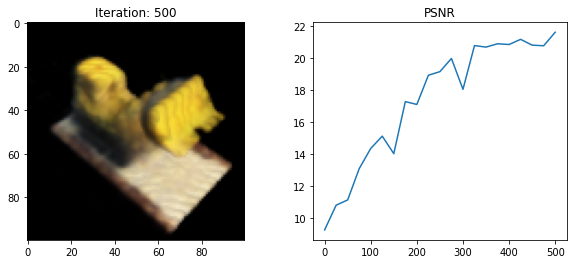

525 1.696839780807495 secs per iter


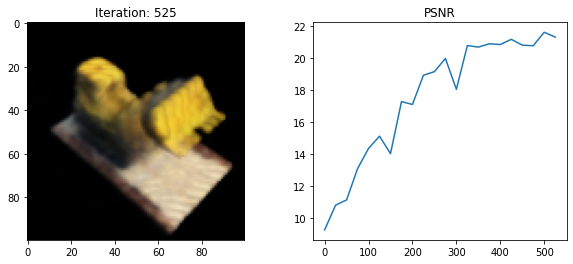

550 1.7030184841156006 secs per iter


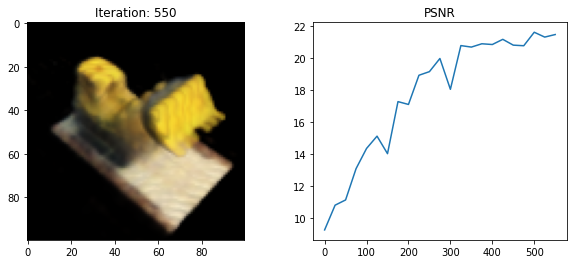

575 1.7106139755249024 secs per iter


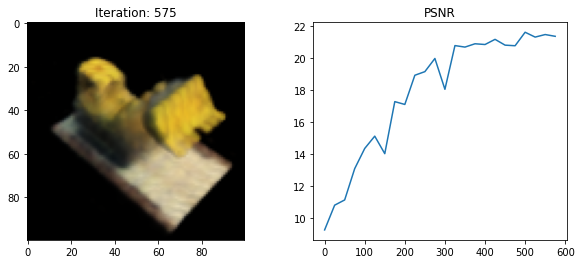

600 1.7103672790527344 secs per iter


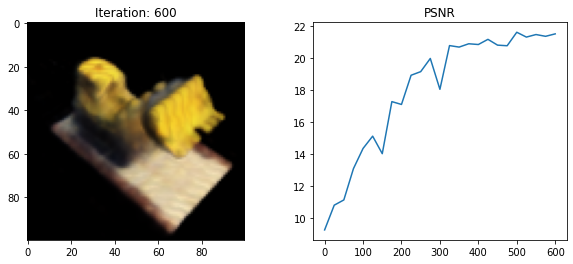

625 1.6975557613372803 secs per iter


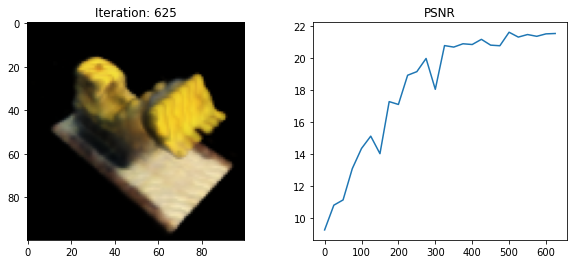

650 1.7087831020355224 secs per iter


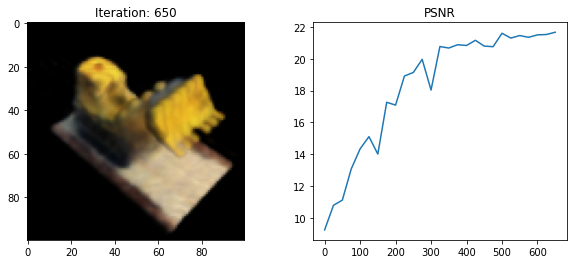

675 1.7087310028076172 secs per iter


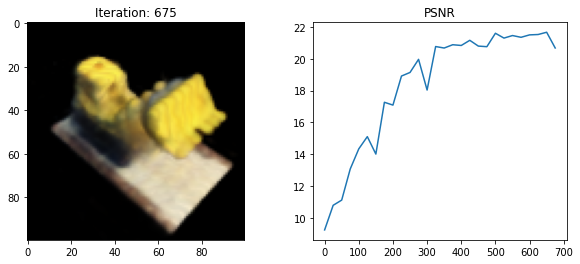

700 1.7099498844146728 secs per iter


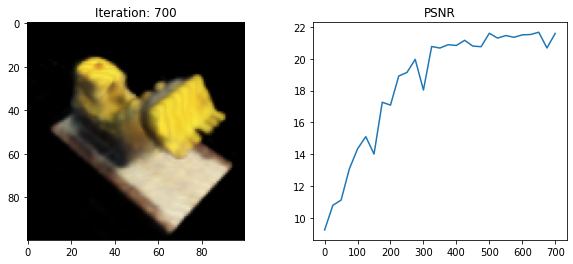

725 1.7013264560699464 secs per iter


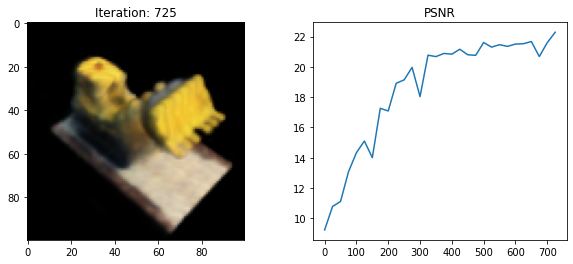

750 1.7063448715209961 secs per iter


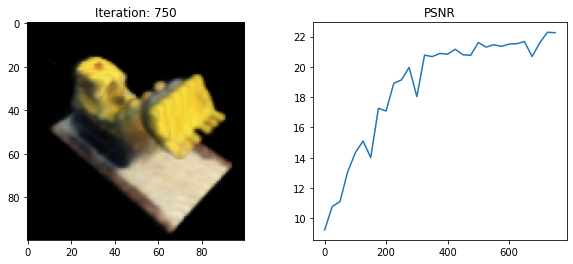

775 1.710120801925659 secs per iter


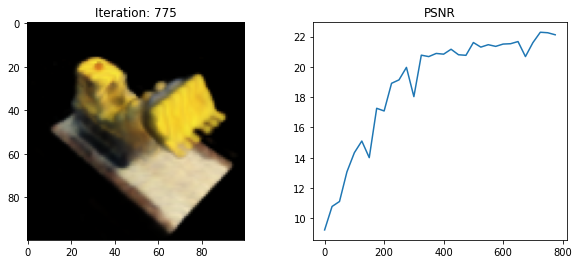

800 1.7075097560882568 secs per iter


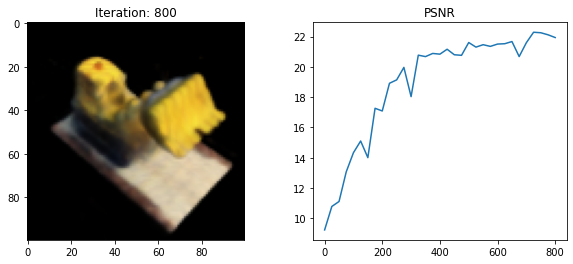

825 1.7002781200408936 secs per iter


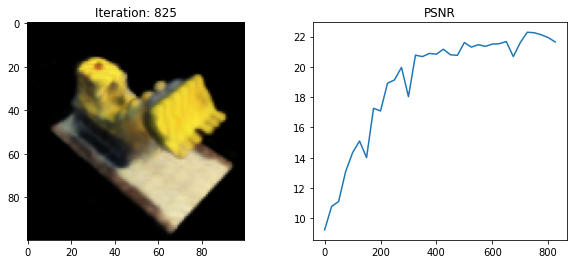

850 1.7084307765960693 secs per iter


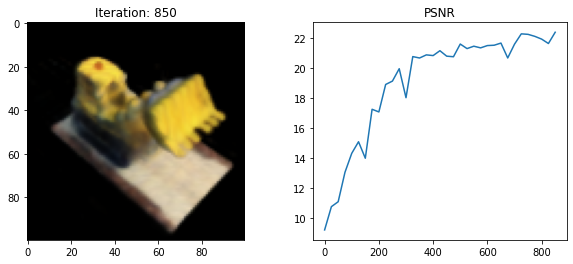

875 1.7105658721923829 secs per iter


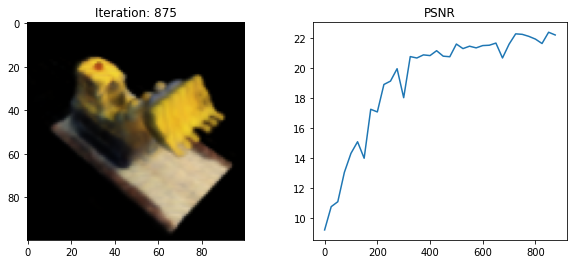

900 1.704504566192627 secs per iter


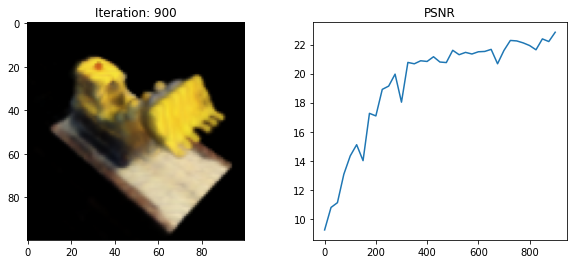

925 1.6966777801513673 secs per iter


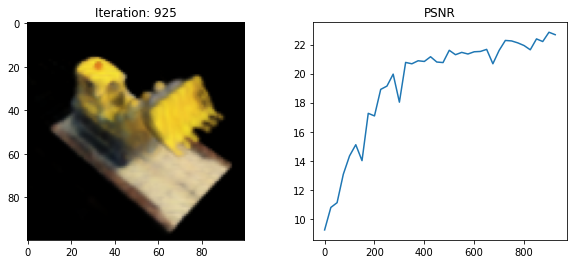

950 1.7088533115386964 secs per iter


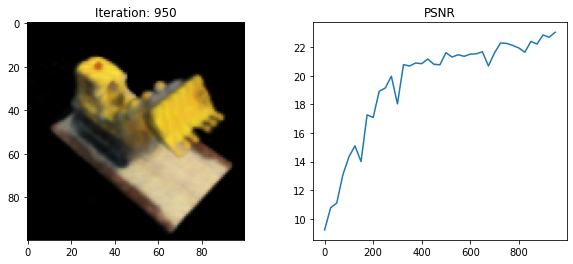

975 1.7050863647460937 secs per iter


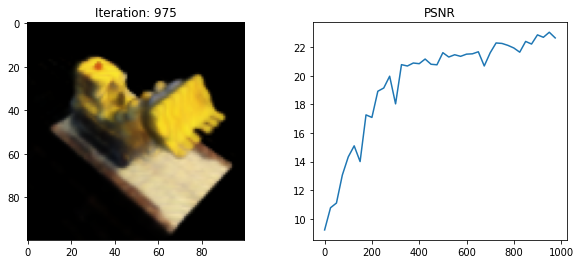

1000 1.703205337524414 secs per iter


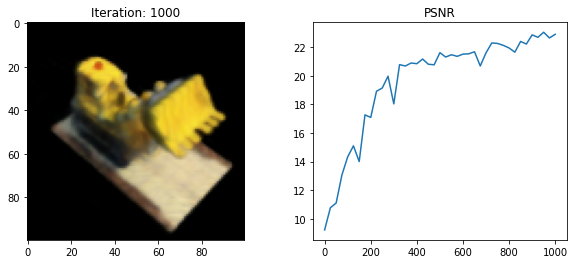

1025 1.6946374130249025 secs per iter


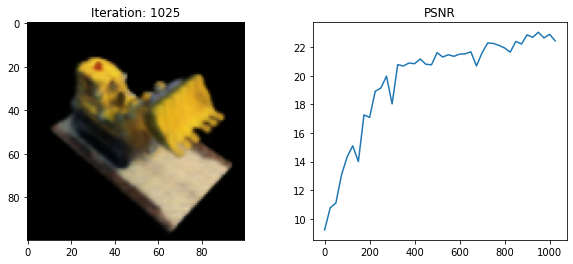

1050 1.7030560207366943 secs per iter


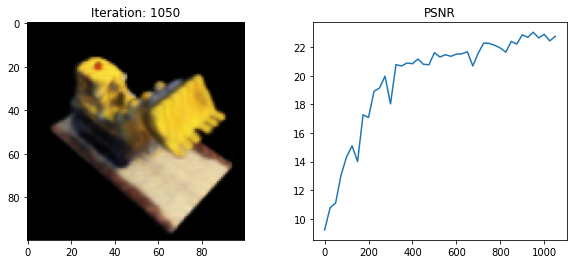

1075 1.7042353630065918 secs per iter


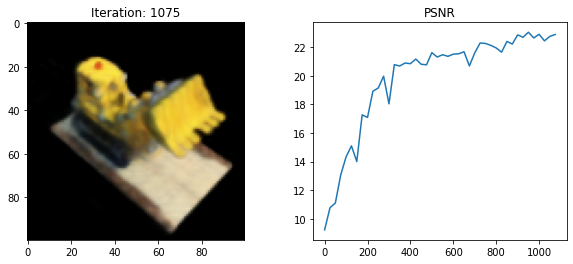

1100 1.7074405097961425 secs per iter


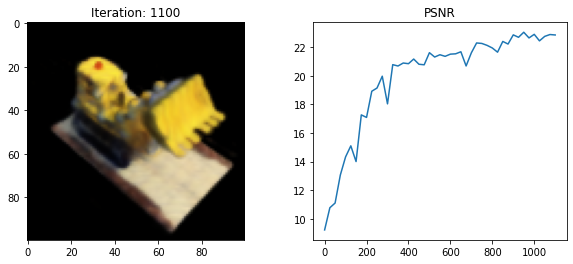

1125 1.6979897689819337 secs per iter


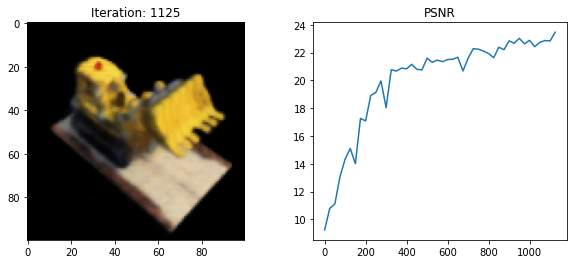

1150 1.6965841388702392 secs per iter


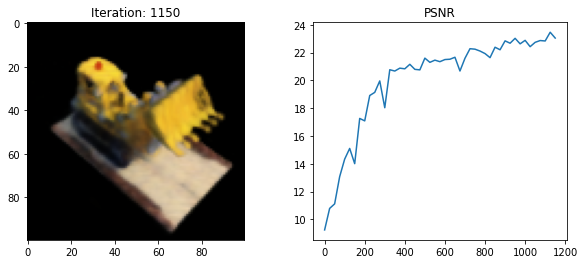

1175 1.7040983963012695 secs per iter


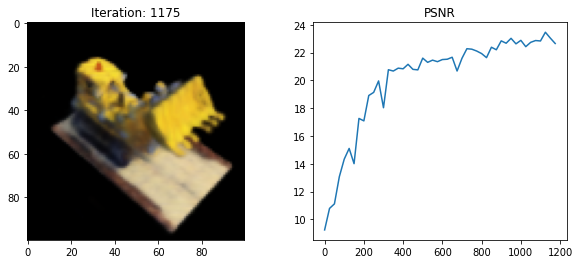

1200 1.7043250846862792 secs per iter


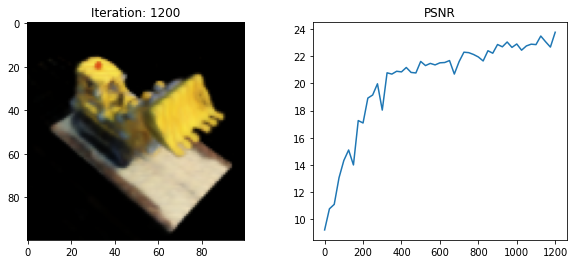

1225 1.7047791194915771 secs per iter


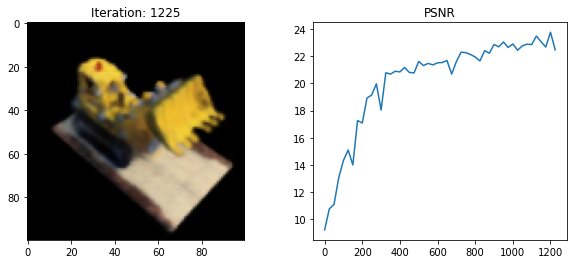

1250 1.6983297157287598 secs per iter


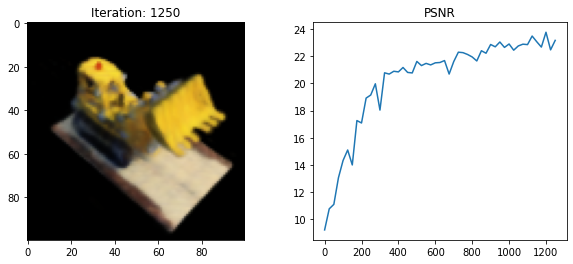

1275 1.6989385032653808 secs per iter


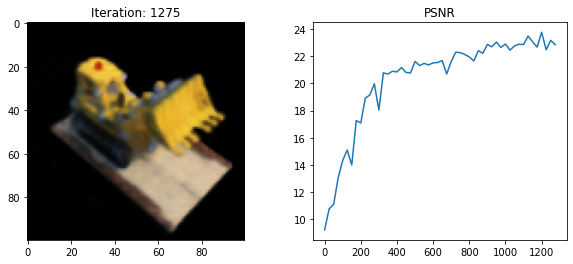

1300 1.703143081665039 secs per iter


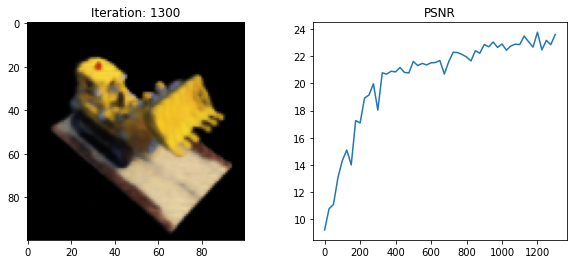

1325 1.7027551460266113 secs per iter


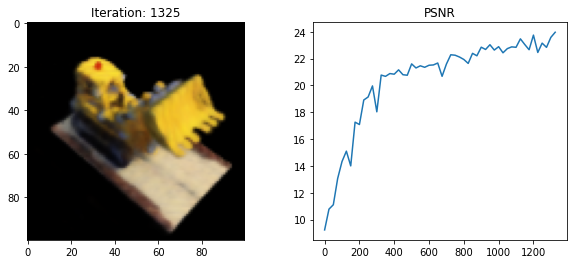

1350 1.7019104480743408 secs per iter


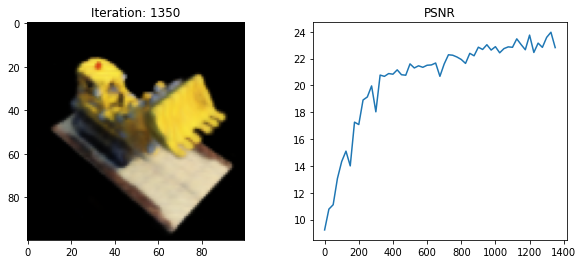

1375 1.6990366935729981 secs per iter


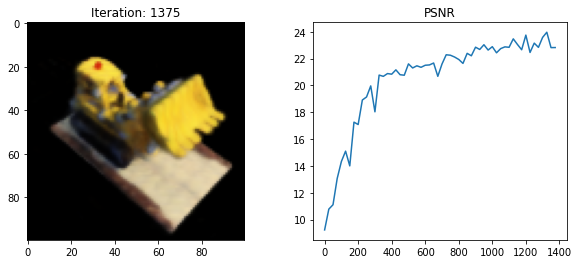

1400 1.7034082317352295 secs per iter


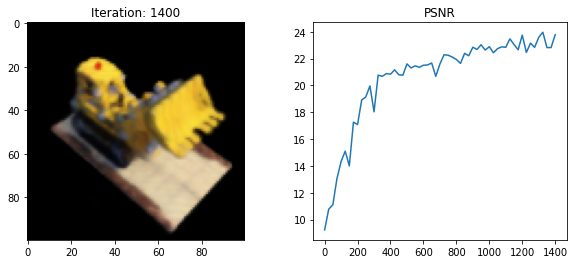

1425 1.707956132888794 secs per iter


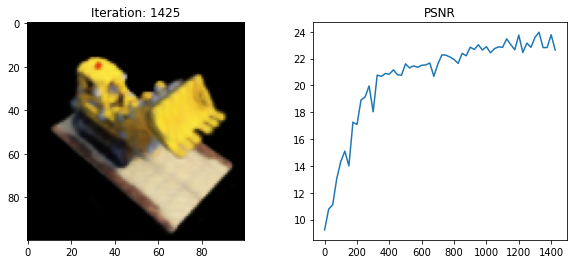

1450 1.6994933700561523 secs per iter


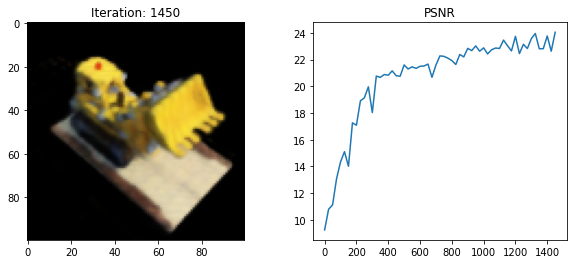

1475 1.6960748291015626 secs per iter


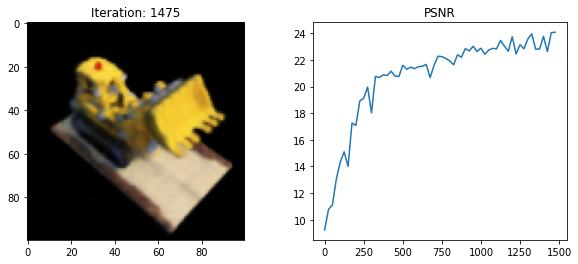

1500 1.6944822883605957 secs per iter


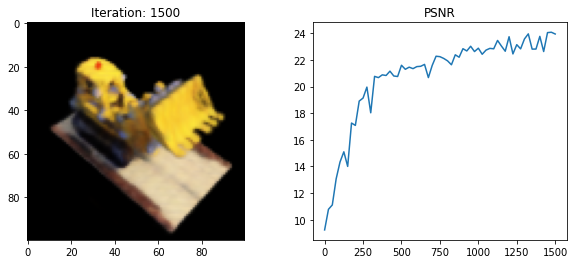

1525 1.7004976081848144 secs per iter


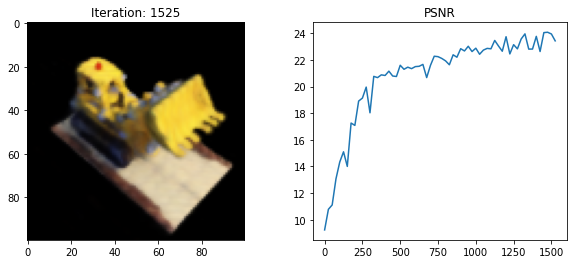

1550 1.7015924835205078 secs per iter


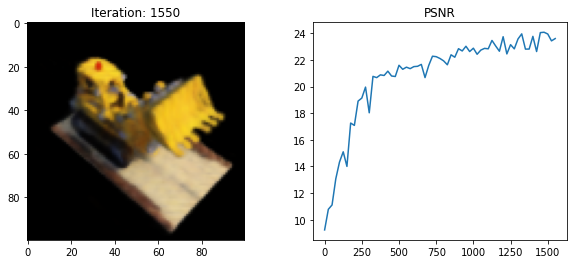

1575 1.7044766330718994 secs per iter


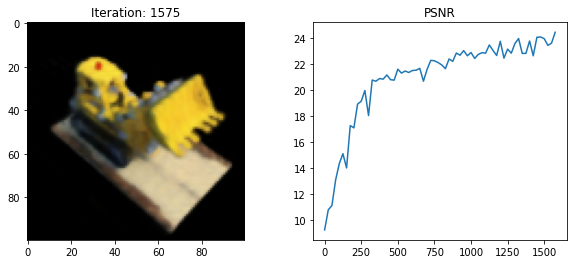

1600 1.6982346153259278 secs per iter


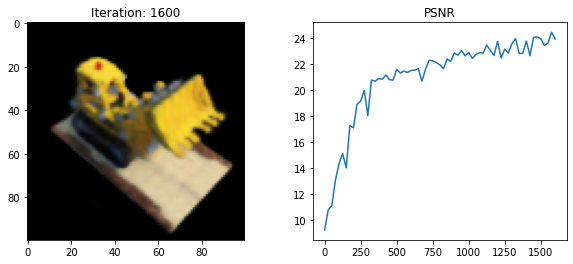

1625 1.6980860710144043 secs per iter


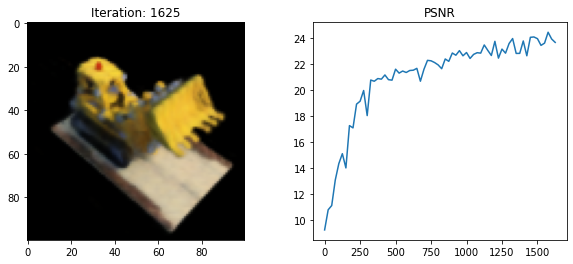

1650 1.7044509696960448 secs per iter


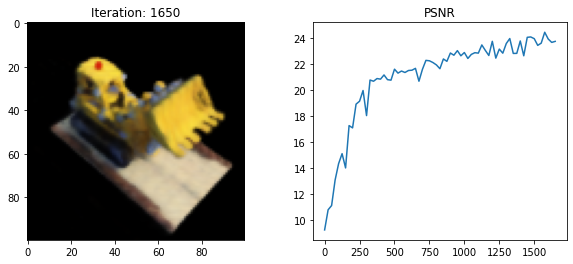

1675 1.7053065872192383 secs per iter


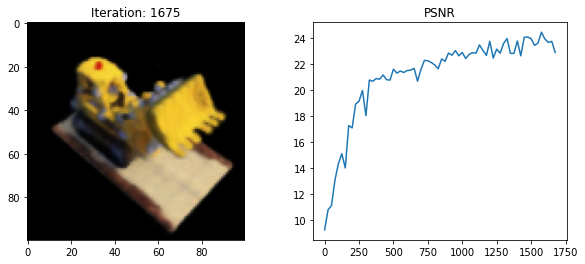

1700 1.7024728393554687 secs per iter


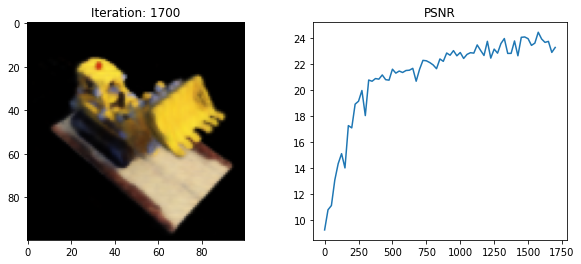

1725 1.6976918029785155 secs per iter


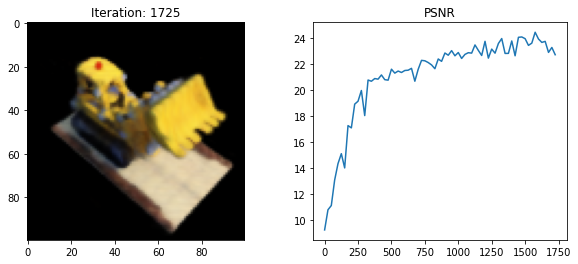

1750 1.701776933670044 secs per iter


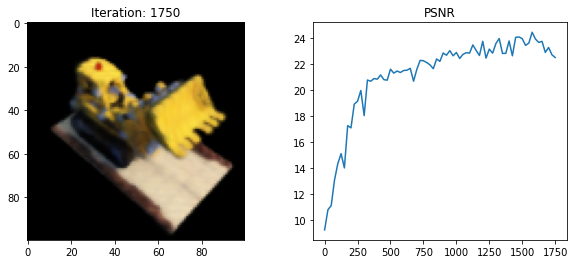

1775 1.7107707118988038 secs per iter


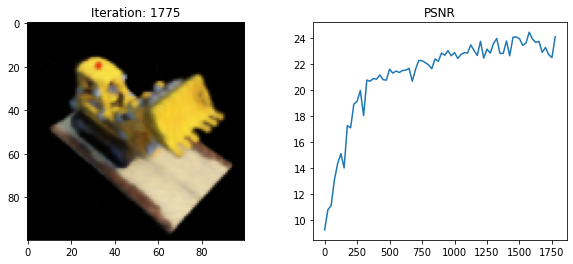

1800 1.7018332195281982 secs per iter


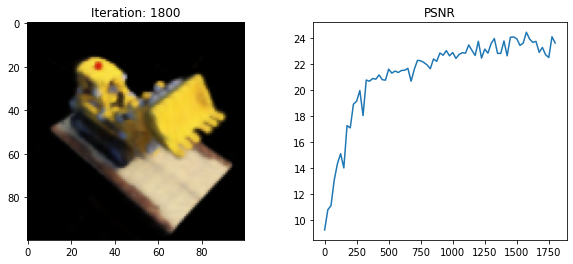

1825 1.6988665771484375 secs per iter


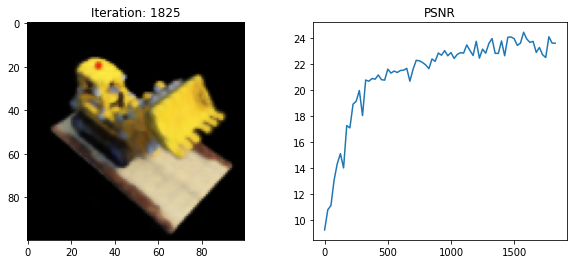

1850 1.7032846355438231 secs per iter


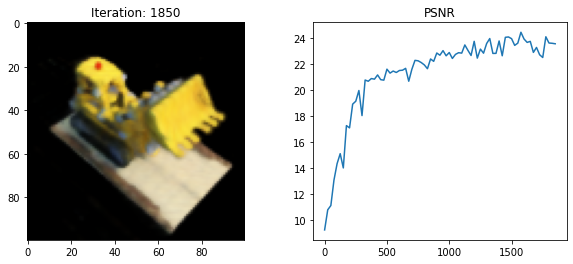

1875 1.7023691844940185 secs per iter


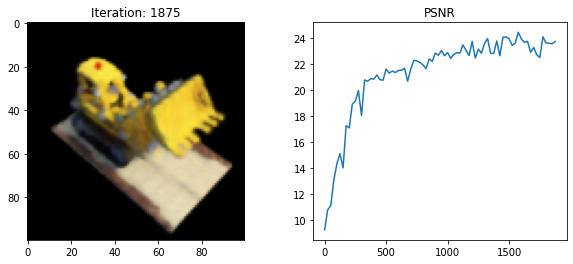

1900 1.7038748264312744 secs per iter


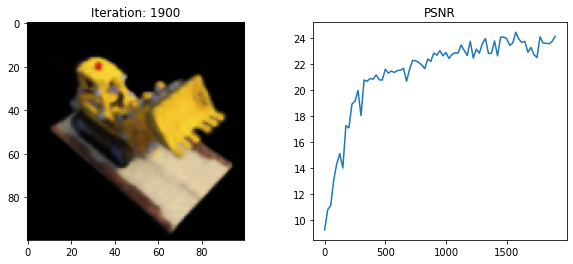

1925 1.6918284320831298 secs per iter


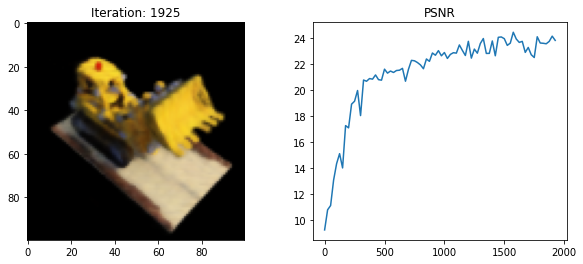

1950 1.6978500080108643 secs per iter


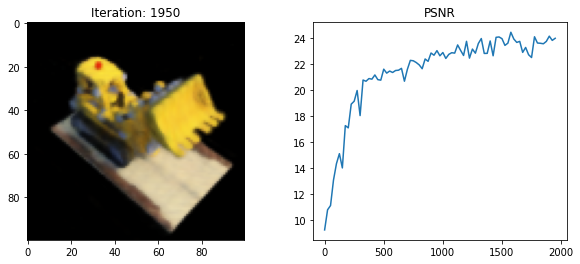

1975 1.7026872158050537 secs per iter


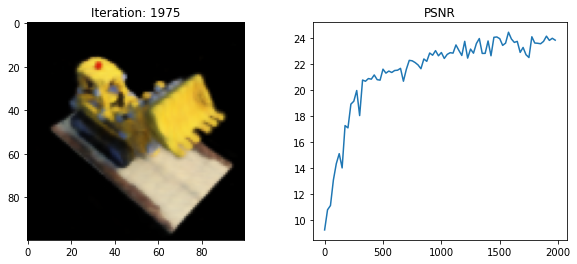

2000 1.7033649063110352 secs per iter


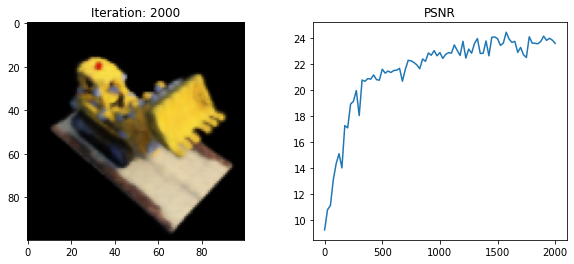

2025 1.7016931533813477 secs per iter


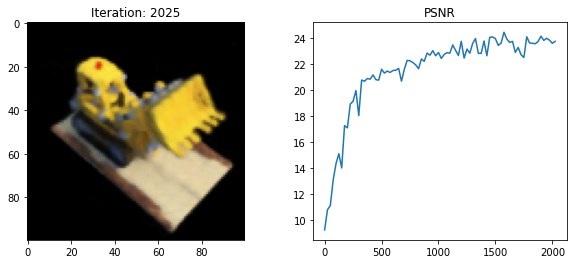

2050 1.6953753089904786 secs per iter


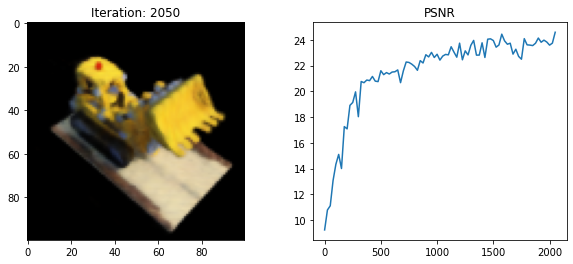

2075 1.6986957931518554 secs per iter


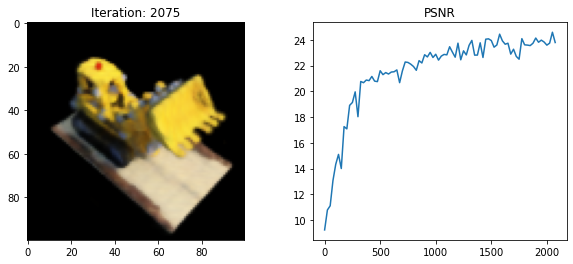

2100 1.7025703716278076 secs per iter


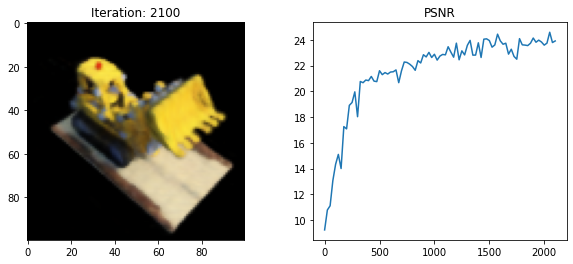

2125 1.7032778644561768 secs per iter


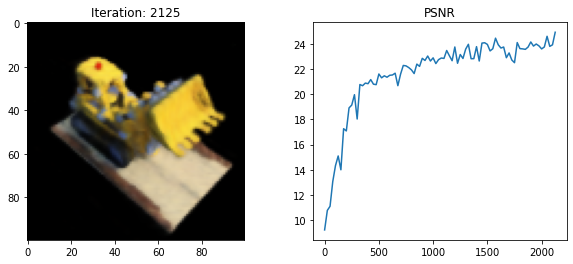

2150 1.6982754039764405 secs per iter


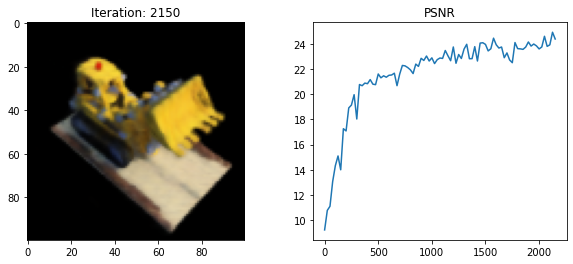

2175 1.6963961124420166 secs per iter


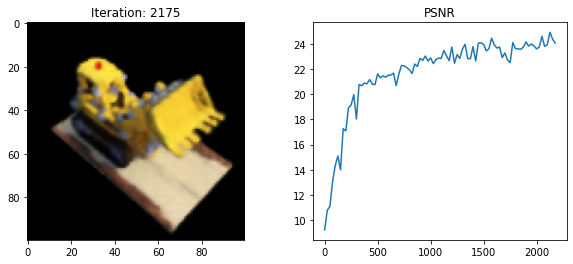

2200 1.6955554008483886 secs per iter


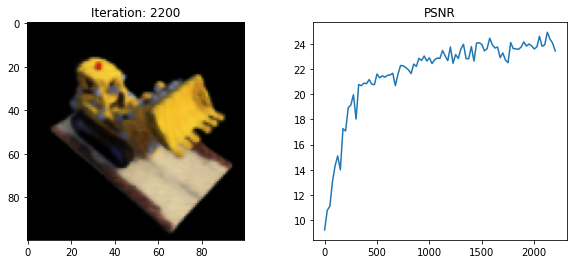

2225 1.693049669265747 secs per iter


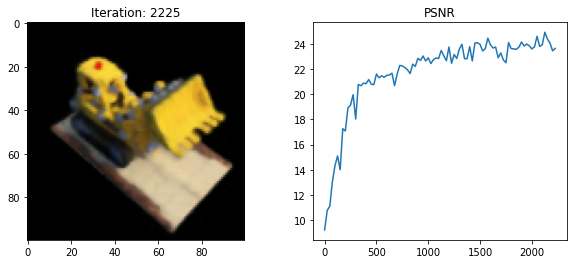

2250 1.6959299087524413 secs per iter


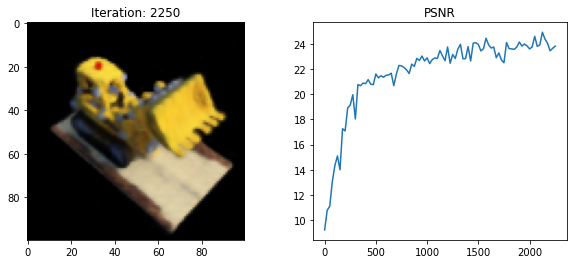

2275 1.693111505508423 secs per iter


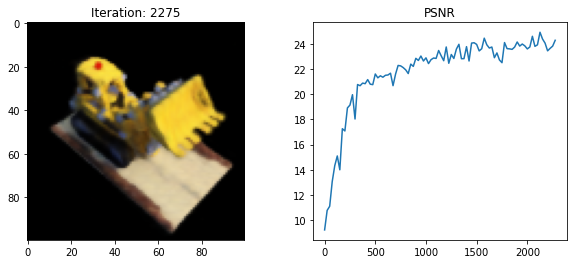

2300 1.6949633216857911 secs per iter


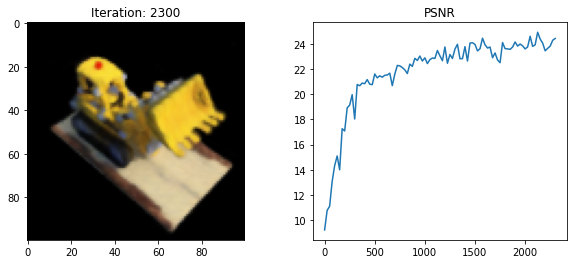

2325 1.6923816108703613 secs per iter


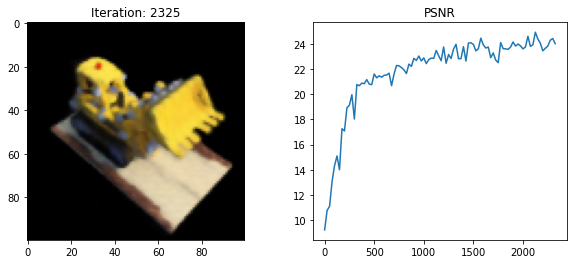

2350 1.6979162788391113 secs per iter


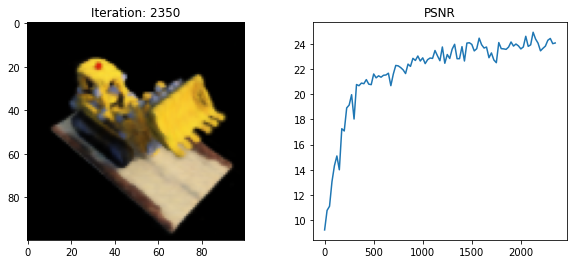

2375 1.6949232959747313 secs per iter


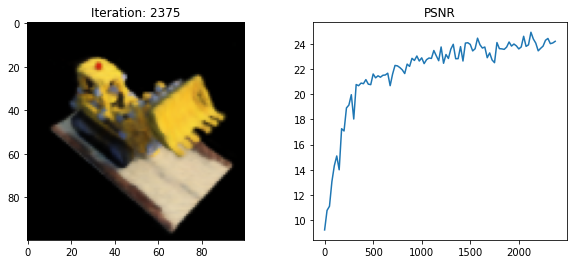

KeyboardInterrupt: ignored

In [12]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 5000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [14]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [15]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [16]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)